In [1]:
import numpy as np
import pandas as pd
import math

In [6]:
def generate_sinusoidal_generation(G0, A, omega, t):
    """Generate sinusoidal generation profile."""
    return G0 + A * np.sin(omega * t)

def simulate_system(
    alpha_e, eta_e2c, alpha_c, eta_c2e,
    L_hat, dt, T_hours,
    G0, A, period_h,
    S0,
    S_max = None
):
    RTE = eta_c2e * alpha_c * eta_e2c       # round-trip efficiency
    N = int(T_hours / dt)                   # number of time steps
    t = np.arange(N) * dt                   # discrete time array
    omega = 2 * math.pi / period_h          # frequency

    # Sinusoidal generation
    G = generate_sinusoidal_generation(G0, A, omega, t)

    beta = np.zeros(N)                      # fraction to storage
    alpha_mix = np.zeros(N)
    S = np.zeros(N + 1)
    S[0] = S0

    L_out = np.zeros(N)
    shed = np.zeros(N)
    spill = np.zeros(N)

    for k in range(N):
        Gk = max(G[k], 0.0)  # enforce G >= 0

        # Ideal beta to meet L_hat exactly without changing S
        if Gk > 0 and abs(RTE - alpha_e) > 1e-12:
            beta_star = (L_hat / Gk - alpha_e) / (RTE - alpha_e)
        else:
            beta_star = 0.0

        # Clip beta to [0, 1]
        beta[k] = min(1.0, max(0.0, beta_star))
        alpha_mix[k] = alpha_e + beta[k] * (RTE - alpha_e)

        # Desired storage change to hit L_hat
        dS_desired = (dt / eta_c2e) * (alpha_mix[k] * Gk - L_hat)
        S_next = S[k] + dS_desired

        # Enforce storage bounds
        if S_max is None:
            # unlimited upper bound, only apply lower bound
            S[k+1] = max(0.0, S_next)
        else:
            # bounded storage, apply both bounds
            S[k+1] = min(S_max, max(0.0, S_next))

        # Actual output given resulting S change
        L_out[k] = alpha_mix[k] * Gk - eta_c2e * (S[k+1] - S[k]) / dt

        # Shed and spill
        shed[k]  = max(0.0, L_hat - L_out[k])
        spill[k] = max(0.0, L_out[k] - L_hat) if S_max is not None else 0.0

    df = pd.DataFrame({
        "t": t,
        "G": G,
        "beta": beta,
        "alpha_mix": alpha_mix,
        "S": S[:-1],
        "S_next": S[1:],
        "L_out": L_out,
        "L_target": L_hat,
        "shed": shed,
        "spill": spill
    })
    return df

# Example usage:
# df = simulate_unbounded_storage()
# df.to_csv("unbounded_storage_results.csv", index=False)


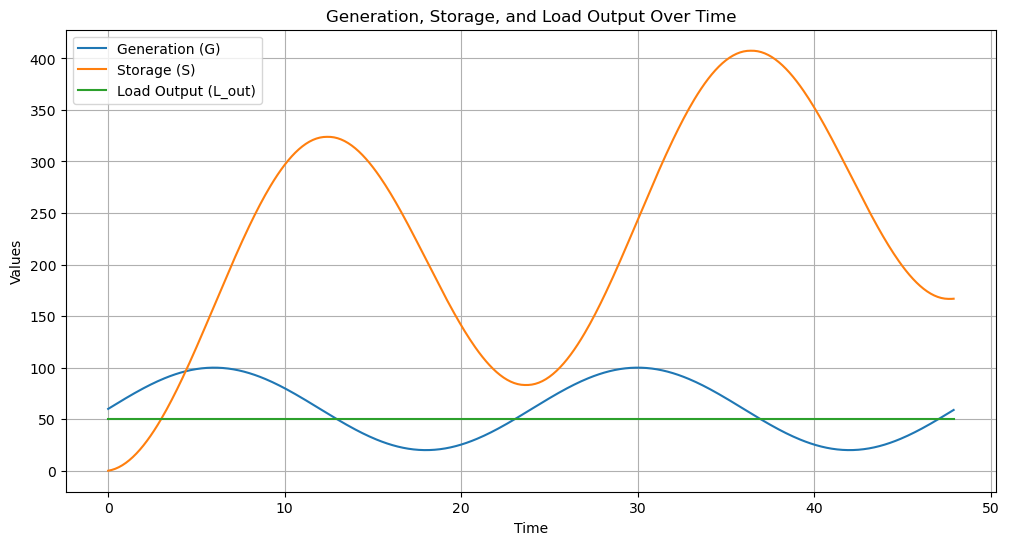

In [7]:
import matplotlib.pyplot as plt

df = simulate_system(
    alpha_e=0.9, eta_e2c=0.95,
    alpha_c=0.98, eta_c2e=0.95,
    L_hat=50, dt=0.1, T_hours=48,
    G0=60, A=40, period_h=24,
    S0=0,
    S_max=None
)

# Plot G, S, and L_out over time
plt.figure(figsize=(12, 6))
plt.plot(df['t'], df['G'], label='Generation (G)')
plt.plot(df['t'], df['S'], label='Storage (S)')
plt.plot(df['t'], df['L_out'], label='Load Output (L_out)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Generation, Storage, and Load Output Over Time')
plt.legend()
plt.grid()
plt.show()

In [ ]:
class Params:
    def __init__(
        self,
        alpha_e=0.90,      # efficiency E1 -> E2 (direct electricity)
        eta_e2c=0.95,      # efficiency E1 -> C1 (electric -> fuel)
        alpha_c=0.98,      # efficiency C1 -> C2 (fuel transport)
        eta_c2e=0.95,      # efficiency C2 -> E2 (fuel -> electric)
        dt=0.25,           # time step [hours]
        T_hours=48,        # total simulation time [hours]
        L_hat=10.0,         # target load (constant) [power]
        G0=10.0,           # mean generation [power]
        A=5.0,             # amplitude of sinusoidal generation [power]
        period_h=12.0,     # period of sinusoidal generation [hours]
        C1_0=0.0,          # initial fuel in C1 [energy]
        C2_0=0.0           # initial fuel in C2 [energy]
    ):
        self.alpha_e = alpha_e
        self.eta_e2c = eta_e2c
        self.alpha_c = alpha_c
        self.eta_c2e = eta_c2e
        self.dt = dt
        self.T_hours = T_hours
        self.L_hat = L_hat
        self.G0 = G0
        self.A = A
        self.period_h = period_h
        self.C1_0 = C1_0
        self.C2_0 = C2_0

        # Round-trip efficiency via storage path E1 -> C1 -> C2 -> E2
        self.k_rt = self.eta_c2e * self.alpha_c * self.eta_e2c

def controller_single_load(params, Gk, C1_k, C2_k):
    """
    Given:
      - params: Params object
      - Gk: generation at time step k (power)
      - C1_k, C2_k: current fuel in C1, C2 (energy)

    Returns:
      f_e, x1, f_c, x2  (all ≥ 0, in power units)

    Policy:
      1. Use direct electricity E1->E2 (f_e) as much as possible to meet L_hat.
      2. Use fuel at C2 (x2) to cover any remaining load.
      3. Use any leftover generation to charge C1 (x1).
      4. Optionally move fuel C1->C2 (f_c) to keep them balanced (to show "transport").
    """
    dt = params.dt
    alpha_e = params.alpha_e
    eta_e2c = params.eta_e2c
    alpha_c = params.alpha_c
    eta_c2e = params.eta_c2e
    L_hat = params.L_hat

    Gk = max(Gk, 0.0)   # enforce non-negative generation

    # 1) Direct electric supply from E1 -> E2
    # Max direct power to load from G: alpha_e * f_e ≤ L_hat
    # so f_e ≤ L_hat / alpha_e, but also f_e ≤ Gk
    if alpha_e > 0:
        f_e = min(Gk, L_hat / alpha_e)
    else:
        f_e = 0.0

    L_direct = alpha_e * f_e
    L_rem = max(0.0, L_hat - L_direct)

    # 2) Remaining load from C2 -> E2 (fuel -> electric)
    # x2 power draw limited by what's in C2: x2 * dt ≤ C2_k
    if eta_c2e > 0 and dt > 0:
        x2_max_energy = C2_k / dt
        x2_needed = L_rem / eta_c2e
        x2 = min(x2_needed, x2_max_energy)
    else:
        x2 = 0.0

    L_from_storage = eta_c2e * x2
    L_total = L_direct + L_from_storage

    # 3) Use any leftover generation to charge C1 (E1 -> C1)
    # Node E1 balance: Gk = f_e + x1  (no other electric outflows in this simple model)
    x1 = max(0.0, Gk - f_e)

    # 4) Move some fuel from C1 -> C2 to "demonstrate transport"
    # Simple heuristic: try to equalize C1 and C2
    total_fuel = C1_k + C2_k + dt * eta_e2c * x1  # including fuel that will be added to C1 this step
    target_C2 = total_fuel / 2.0
    # Desired change in C2 over the step to move towards target
    desired_dC2 = target_C2 - C2_k

    # C2 dynamics: C2_{k+1} = C2_k + dt (alpha_c f_c - x2)
    # So desired_dC2 ≈ dt (alpha_c f_c - x2)  => f_c ≈ (desired_dC2/dt + x2) / alpha_c
    if alpha_c > 0 and dt > 0:
        f_c_raw = (desired_dC2 / dt + x2) / alpha_c
        f_c = max(0.0, f_c_raw)  # don't allow negative transport (could add reverse flow if you want)
        # But limited by available C1 fuel this step: f_c * dt ≤ C1_k + dt * eta_e2c * x1
        max_fuel_C1 = C1_k + dt * eta_e2c * x1
        f_c = min(f_c, max_fuel_C1 / dt)
    else:
        f_c = 0.0

    # Return flows
    return f_e, x1, f_c, x2, L_total


def simulate_explicit(params):
    """
    Simulate the system with explicit nodes:
      G -> E1 -> {E2, C1}
      C1 -> C2
      C2 -> E2 -> L

    Returns a pandas DataFrame with time series.
    """
    dt = params.dt
    N = int(params.T_hours / dt)
    t = np.arange(N) * dt

    # Sinusoidal generation G(t)
    omega = 2 * math.pi / params.period_h
    G = params.G0 + params.A * np.sin(omega * t)
    G = np.maximum(G, 0.0)

    # State: fuel in C1, C2
    C1 = np.zeros(N + 1)
    C2 = np.zeros(N + 1)
    C1[0] = params.C1_0
    C2[0] = params.C2_0

    # Flows and outputs
    f_e = np.zeros(N)   # E1 -> E2 (electric)
    x1  = np.zeros(N)   # E1 -> C1 (electric -> fuel)
    f_c = np.zeros(N)   # C1 -> C2 (fuel transport)
    x2  = np.zeros(N)   # C2 -> E2 (fuel -> electric)
    L_out = np.zeros(N) # E2 -> L (achieved load)
    shed = np.zeros(N)  # unmet load (if any)

    alpha_e  = params.alpha_e
    eta_e2c  = params.eta_e2c
    alpha_c  = params.alpha_c
    eta_c2e  = params.eta_c2e
    L_hat    = params.L_hat

    for k in range(N):
        # --- Node G: generation G[k] goes into node E1 ---
        Gk = G[k]

        # --- Controller chooses flows based on current state ---
        f_e_k, x1_k, f_c_k, x2_k, L_total = controller_single_load(
            params, Gk, C1[k], C2[k]
        )

        # Enforce non-negativity and E1 node balance: Gk >= f_e + x1
        f_e_k = max(0.0, f_e_k)
        x1_k  = max(0.0, x1_k)
        if f_e_k + x1_k > Gk + 1e-9:  # tiny tolerance
            # scale down proportionally if round-off causes a small violation
            scale = Gk / (f_e_k + x1_k)
            f_e_k *= scale
            x1_k  *= scale

        # Enforce that fuel flows don't exceed available fuel
        # C1 dynamics: C1_{k+1} = C1_k + dt (eta_e2c x1 - f_c)
        # So f_c * dt ≤ C1_k + dt * eta_e2c * x1_k
        max_C1_this_step = C1[k] + dt * eta_e2c * x1_k
        if f_c_k * dt > max_C1_this_step + 1e-9:
            f_c_k = max_C1_this_step / dt

        # Similarly for C2: x2 * dt ≤ C2_k + dt * alpha_c * f_c
        max_C2_this_step = C2[k] + dt * alpha_c * f_c_k
        if x2_k * dt > max_C2_this_step + 1e-9:
            x2_k = max_C2_this_step / dt

        # --- Update states C1, C2 ---
        C1[k+1] = C1[k] + dt * (eta_e2c * x1_k - f_c_k)
        C2[k+1] = C2[k] + dt * (alpha_c * f_c_k - x2_k)

        # Enforce non-negative storage
        C1[k+1] = max(0.0, C1[k+1])
        C2[k+1] = max(0.0, C2[k+1])

        # --- Compute actual electrical output at node E2 ---
        L_out_k = alpha_e * f_e_k + eta_c2e * x2_k

        f_e[k] = f_e_k
        x1[k]  = x1_k
        f_c[k] = f_c_k
        x2[k]  = x2_k
        L_out[k] = L_out_k

        # Shed = unmet part of target load
        shed[k] = max(0.0, L_hat - L_out_k)

    # Build DataFrame
    df = pd.DataFrame({
        "t": t,
        "G": G,
        "C1": C1[:-1],
        "C1_next": C1[1:],
        "C2": C2[:-1],
        "C2_next": C2[1:],
        "f_e": f_e,
        "x1": x1,
        "f_c": f_c,
        "x2": x2,
        "L_out": L_out,
        "L_target": L_hat,
        "shed": shed,
    })

    return df


params = Params(
    alpha_e=0.90,
    eta_e2c=0.95,
    alpha_c=0.98,
    eta_c2e=0.95,
    dt=0.25,
    T_hours=48,
    L_hat=9.0,
    G0=10.0,
    A=5.0,
    period_h=12.0,
    C1_0=0.0,
    C2_0=0.0,
)

df = simulate_explicit(params)
df.to_csv("explicit_two_tank_storage.csv", index=False)
print(df.head())


Wrote explicit_two_tank_storage.csv
      t          G        C1   C1_next        C2   C2_next   f_e        x1  \
0  0.00  10.000000  0.000000  0.000000  0.000000  0.000000  10.0  0.000000   
1  0.25  10.652631  0.000000  0.075918  0.000000  0.077500  10.0  0.652631   
2  0.50  11.294095  0.075918  0.227263  0.077500  0.230383  10.0  1.294095   
3  0.75  11.913417  0.227263  0.451436  0.230383  0.456041  10.0  1.913417   
4  1.00  12.500000  0.451436  0.744602  0.456041  0.750614  10.0  2.500000   

        f_c   x2  L_out  L_target  shed  
0  0.000000  0.0    9.0       9.0   0.0  
1  0.316326  0.0    9.0       9.0   0.0  
2  0.624012  0.0    9.0       9.0   0.0  
3  0.921054  0.0    9.0       9.0   0.0  
4  1.202336  0.0    9.0       9.0   0.0  


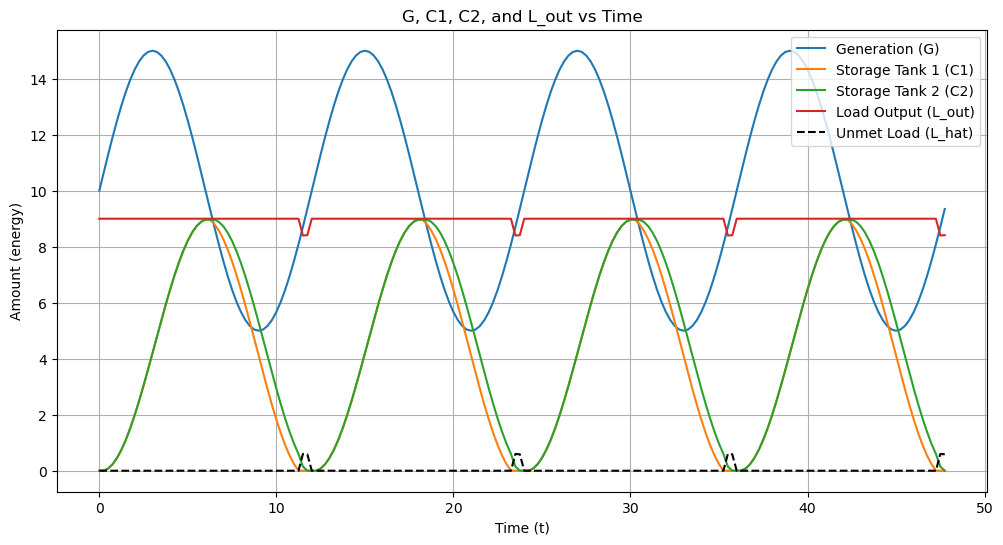

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(df['t'], df['G'], label='Generation (G)')
plt.plot(df['t'], df['C1'], label='Storage Tank 1 (C1)')
plt.plot(df['t'], df['C2'], label='Storage Tank 2 (C2)')
plt.plot(df['t'], df['L_out'], label='Load Output (L_out)')
plt.plot(df['t'], df['shed'], 'k--', label='Unmet Load (L_hat)')
plt.xlabel('Time (t)')
plt.ylabel('Amount (energy)')
plt.title('G, C1, C2, and L_out vs Time')
plt.legend()
plt.grid()
plt.show()